In [1]:
# !pip install mlforecast lightgbm -q

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

from lightgbm import LGBMRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint

import optuna

from mlforecast import MLForecast
from mlforecast.lag_transforms import (
    ExpandingMean,
    RollingMean,
    ExponentiallyWeightedMean,
)
from mlforecast.target_transforms import Differences
from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)

from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mae, rmse

import time
import datetime

In [3]:
forecast_horizon = 24

In [4]:
df = pd.read_csv(
    "../data/consumption.csv", usecols=["prediction_unit_id", "datetime", "target"]
)[["prediction_unit_id", "datetime", "target"]].rename(
    columns={"prediction_unit_id": "unique_id", "datetime": "ds", "target": "y"}
)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [5]:
df["y"] = df["y"].ffill()
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

# Train/Test split

In [6]:
# taking the last 60 days for test
test_duration = 24 * 60
for i in df["unique_id"].unique():
    if i == df["unique_id"].unique()[0]:
        df_test = df[df["unique_id"]==i][-test_duration:]
        continue
    df_test = pd.concat([df_test, df[df["unique_id"]==i][-test_duration:]])
    
df_test.sort_index(inplace=True)
print(df_test.shape)
df_test.head()

(99360, 3)


,unique_id,ds,y
684254,68,2022-11-10 00:00:00,28.124
684323,68,2022-11-10 01:00:00,28.020
684392,68,2022-11-10 02:00:00,28.741
684461,68,2022-11-10 03:00:00,31.947
684530,68,2022-11-10 04:00:00,36.197


In [7]:
train_idx = [idx for idx in df.index if idx not in df_test.index]
df_train = df.loc[train_idx]
df_train.shape
df_train.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [8]:
df.shape[0] == df_train.shape[0] + df_test.shape[0]

True

In [9]:
df.shape[1] == df_train.shape[1] == df_test.shape[1]

True

In [10]:
test_size = df_test.shape[0] / (df_train.shape[0] + df_test.shape[0])
print(f"test size : {round(test_size, 3)*100}0%")

test size : 9.80%


# Training

In [11]:
# col_params = dict(id_col="building_id", time_col="datetime", target_col="consumption")
# col_params

In [12]:
lgb_params = {
    "verbosity": -1,
    "num_leaves": 512,
}

fcst = MLForecast(
    models={
        "lgb": LGBMRegressor(**lgb_params),
        # 'q75': LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        # 'q25': LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq="h",
    target_transforms=[Differences([24])],
    lags=[i + 1 for i in range(48)],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

# fcst.preprocess(df_train, **col_params).head()
fcst.preprocess(df_train).head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag44,lag45,lag46,lag47,lag48,expanding_mean_lag1,rolling_mean_lag24_window_size48,month,dayofweek,hour
5795,0,2021-09-04 23:00:00,-6.630,10.176,-16.948,30.391,7.926,-17.201,-3.185,6.491,...,-8.897,-8.661,-15.113,-2.237,-6.991,4.519704,5.480750,9,5,23
5796,1,2021-09-04 23:00:00,-0.656,4.648,5.220,-13.346,-10.982,-2.404,-1.357,1.997,...,-1.600,-2.184,2.200,-1.378,-0.827,0.645268,0.864937,9,5,23
5797,2,2021-09-04 23:00:00,-35.639,-62.993,5.519,17.114,47.251,-16.126,-23.379,32.545,...,-102.505,-68.646,-42.397,-44.788,-21.684,33.502592,38.503042,9,5,23
5798,3,2021-09-04 23:00:00,-1.100,-4.200,-3.600,-4.900,-17.900,-16.500,-38.600,-10.800,...,-18.700,-17.200,-19.300,-11.700,-5.500,-7.554930,4.497917,9,5,23
5799,4,2021-09-04 23:00:00,-68.429,-83.631,-70.391,-16.480,-11.291,-59.362,-127.090,-178.232,...,-0.884,-46.453,-51.881,27.731,-9.685,-38.533958,21.538812,9,5,23


In [13]:
start = time.time()
# fcst.fit(df_train, **col_params)
fcst.fit(df_train)
end = time.time()
t = end - start
t

5.523423194885254

# Evaluate

In [14]:
df_eval = pd.merge(df_test, fcst.predict(test_duration), on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [15]:
error_ref = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train  # , **col_params
)
error_ref.drop(columns=["unique_id"]).groupby("metric").mean()

,lgb
metric,
mae,79.357851
mape,1.714142
mase,1.645486
rmse,106.346291


# Error distribution

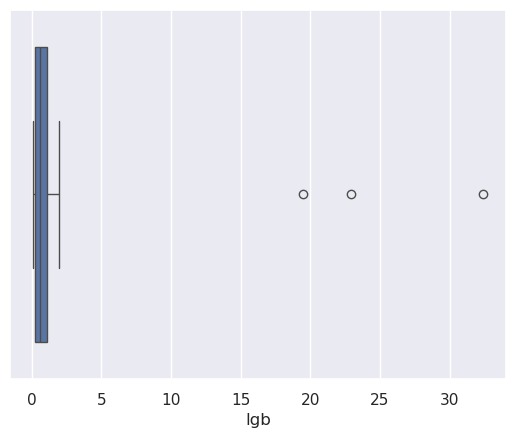

In [16]:
mask = error_ref["metric"] == "mape"
sns.boxplot(x=error_ref.loc[mask, "lgb"])
plt.show()

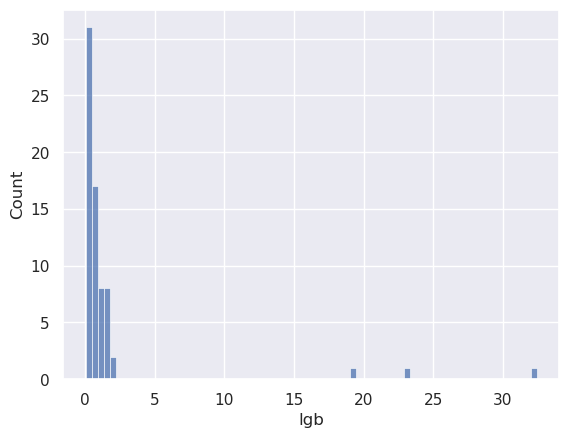

In [17]:
sns.histplot(x=error_ref.loc[mask, "lgb"])
plt.show()

# HPO

## Random Search

### Preprocessing

In [18]:
fcst = MLForecast(
    models=[],
    freq="h",
    # target_transforms=[Differences([24])],
    lags=[i + 1 for i in range(47)],
    lag_transforms={
        1: [ExpandingMean()],
        1: [RollingMean(window_size=24)],
        24: [RollingMean(window_size=24)],
        # 24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

fcst.preprocess(df_train).head(1)

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag43,lag44,lag45,lag46,lag47,rolling_mean_lag1_window_size24,rolling_mean_lag24_window_size24,month,dayofweek,hour
2867,0,2021-09-02 23:00:00,120.54,134.986,150.412,152.763,136.13,121.033,80.621,43.428,...,88.184,87.955,91.594,77.691,96.59,87.588333,79.96975,9,3,23


In [19]:
# fcst.preprocess(df_train.groupby("unique_id").head(48)).head(1)

In [20]:
X_train = fcst.preprocess(df_train).rename(columns={"y": "lag0"})
# X_train.head(3)

In [21]:
X_train, y_train = X_train.align(
    df_train.groupby("unique_id")["y"].shift(-24).rename("lead24").dropna(),
    axis=0,
    join="inner",
)
X_train.shape, y_train.shape

((904917, 55), (904917,))

### Random Search

In [ ]:
# param_dist = {
#     "learning_rate": np.logspace(-4, -1),
#     "max_depth": np.arange(1, 20, 1),
#     "num_leaves": np.arange(10, 200, 10),
#     "feature_fraction": np.linspace(0.1, 1.0, 10),
#     "subsample": np.linspace(0.1, 1.0, 10)
# }
param_dist = {
    "num_trees": [
        10, 20, 30, 40, 50, 60, 70, 80, 90,
        100, 200, 300, 400, 500, 600, 700, 800, 900,
        1000, 3000, 5000,
    ],
    "learning_rate": loguniform(0.0001, 0.1),
    "max_depth": randint(1, 30),
    "num_leaves": randint(10, 300),
    "feature_fraction": uniform(0.1, 1.0),
    "subsample": uniform(0.1, 1.0),
}

model = LGBMRegressor(verbosity=-1)
tscv = TimeSeriesSplit(n_splits=10)
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=tscv,
    verbose=0,
    random_state=1,
    n_iter=60,
)
start = time.time()
print("start time :", start)
random_search.fit(X_train.drop(columns=["unique_id", "ds"]), y_train)
end = time.time()
t = end - start

start time : 1715958378.815916


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.4132735169322751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132735169322751
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.4132735169322751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132735169322751
[LightGBM] [Warn

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.wa

[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.4132735169322751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132735169322751
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.4132735169322751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132735169322751
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.5572048079869882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5572048079869882
[LightGBM] [Warning] num_iterations is set=100, num_trees=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] feature_fraction is set=0.5572048079869882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5572048079869882
[LightG

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.5572048079869882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5572048079869882
[LightGBM] [Warning] num_iterations is set=100, num_trees=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] feature_fraction is set=0.5572048079869882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5572048079869882
[LightGBM] [W

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.4134241781592428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134241781592428
[LightGBM] [Warning] num_iterations is set=90, num_trees=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] feature_fraction is set=0.4134241781592428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134241781592428
[LightGBM] [Warn

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.4132735169322751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132735169322751
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.4132735169322751, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4132735169322751
[LightGBM] [Warn

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.4134241781592428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134241781592428
[LightGBM] [Warning] num_iterations is set=90, num_trees=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] feature_fraction is set=0.4134241781592428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134241781592428
[LightGBM] [Warn

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.5572048079869882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5572048079869882
[LightGBM] [Warning] num_iterations is set=100, num_trees=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] feature_fraction is set=0.4134241781592428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4134241781592428
[LightGBM] [W

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=1.057889530150502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.057889530150502
[LightGBM] [Warning] num_iterations is set=20, num_trees=20 will be ignored. Current value: num_iterations=20
[LightGBM] [Warning] feature_fraction is set=0.8833144726948862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8833144726948862
[LightGBM] [Warnin

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 381 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 381 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.4553103624164283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4553103624164283
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.6736794866722858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6736794866722858
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.6736794866722858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6736794866722858
[LightGBM] [Warning] feature_fraction is set=0.6736794866722858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6736794866722858
[LightGBM] [Warning] feature_fraction is set=0.11582124284655629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11582124284655629
[LightGB

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.12621098687771928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12621098687771928
[LightGBM] [Warning] num_iterations is set=20, num_trees=20 will be ignored. Current value: num_iterations=20
[LightGBM] [Warning] feature_fraction is set=0.12621098687771928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12621098687771928
[LightGBM] [Warning] feature_fraction is set=0.12621098687771928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12621098687771928
[LightGBM] [Warning] feature_fraction is set=0.12621098687771928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12621098687771928
[LightGBM] [Warning] num_iterations is set=20, num_trees=20 will be ignored. Current value: num_iterations=20
[LightGBM] [Warning] feature_fraction is set=0.12621098687771928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12621098687771928


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5179265391903386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179265391903386
[LightGBM] [Warning] feature_fraction is set=0.5179265391903386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5179265391903386
[LightGBM] [Warning] feature_fraction is set=0.15991768951221166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15991768951221166
[LightGBM] [Warning] num_iterations is set=10, num_trees=10 will be ignored. Current value: num_iterations=10
[LightGBM] [Warning] feature_fraction is set=0.15991768951221166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15991768951221166
[LightGBM] [Warning] feature_fraction is set=0.15991768951221166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15991768951221166
[LightGBM] [Warning] feature_fraction is set=0.15991768951221166, colsample_bytree=1.0 will be ignored. Current va

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.19617226044546168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19617226044546168
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.19617226044546168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19617226044546168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.19617226044546168, colsample_bytree=1.0 will be ignored. Current value: feature_f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=1.067276330000272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.067276330000272
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.15001808588824264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15001808588824264
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.15001808588824264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15001808588824264
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.15001808588824264, colsample_bytree=1.0 will be i

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.1923385947687978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1923385947687978
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7163289451076759, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7163289451076759
[LightGBM] [Warning] feature_fraction is set=1.067276330000272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.067276330000272
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=1.067276330000272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.067276330000272
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.15001808588824264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15001808588824264
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.993021212

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.23713574962887776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23713574962887776
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] feature_fraction is set=0.7129480927278149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129480927278149
[LightGBM] [Warning] num_iterations is set=80, num_trees=80 will be ignored. Current value: num_iterations=80
[LightGB

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5479801814204182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5479801814204182
[LightGBM] [Warning] feature_fraction is set=0.5479801814204182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5479801814204182
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.5479801814204182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5479801814204182
[LightGBM] [Warning] feature_fraction is set=0.5479801814204182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5479801814204182
[LightGBM] [Warning] feature_fraction is set=0.6710085611850924, colsample_bytree=1.0 will be ignored. Current value: featur

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.517022004702574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.517022004702574
[LightGBM] [Warning] feature_fraction is set=0.37304997421674735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37304997421674735
[LightGBM] [Warning] num_iterations is set=80, num_trees=80 will be ignored. Current value: num_iterations=80
[LightGBM] [Warning] feature_fraction is set=0.37304997421674735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37304997421674735
[LightGBM] [

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: (bagging_fraction) <= (1.0) at /tmp/pip-install-t61ay7cd/lightgbm_209909b797324694bb93af22c12ac527/src/io/config_auto.cpp, line 365 .

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warnin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.24672857490581016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24672857490581016
[LightGBM] [Warning] feature_fraction is set=0.7944001577277451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944001577277451
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.7944001577277451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944001577277451
[LightGBM] [Warning] feature_fraction is set=0.7944001577277451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944001577277451
[LightGBM] [Warning] feature_fraction is set=0.4539390887983019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4539390887983019
[LightGBM] [Warning] num_iterations is set=20, num_trees=20 will be ignored. Current value: num_iterations=20
[LightGB

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.10900799696104294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10900799696104294
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.10900799696104294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10900799696104294
[LightGBM] [Warning] feature_fraction is set=0.10900799696104294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10900799696104294
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[Lig

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] feature_fraction is set=0.6765842163910739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765842163910739
[LightGBM] [Warning] num_iterations is set=40, num_trees=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] feature_fraction is set=0.6765842163910739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765842163910739
[Lig

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.10900799696104294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10900799696104294
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] num_iterations is set=60, num_trees=60 will be ignored. Current value: num_iterations=60
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] feature_fraction is set=0.8538761884612464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8538761884612464
[LightGBM] [Warning] feature_fraction is set=0.3317584645213333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3317584645213333
[LightGBM] [Warning] num_iterations is set=40, num_trees=40 will be ignored. Current value: num_iterations=40
[LightGB

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.8625731346670644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8625731346670644
[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.8625731346670644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8625731346670644
[LightGBM] [Warning] feature_fraction is set=0.8625731346670644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8625731346670644
[LightGBM] [Warning] feature_fraction is set=0.4801411726235504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801411726235504
[LightGBM] [Warning] num_iterations is set=20, num_trees=20 will be ignored. Current value: num_iterations=20
[LightGBM] [Warning] feature_fraction is set=0.4801411726235504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801411726235504
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.4801411726235504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801411726235504
[LightGBM] [Warning] feature_fraction is set=0.16653648135411495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16653648135411495
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.16653648135411495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16653648135411495
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.16653648135411495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16653648135411495
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.6

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=30, num_trees=30 will be ignored. Current value: num_iterations=30
[LightGBM] [Warning] feature_fraction is set=0.8625731346670644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8625731346670644
[LightGBM] [Warning] feature_fraction is set=0.8625731346670644, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8625731346670644
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[Lig

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.16653648135411495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16653648135411495
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.16653648135411495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16653648135411495
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.6765842163910739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765842163910739
[LightGBM] [Warning] num_iterations is set=40, num_trees=40 will be ignored. Current value: num_iterations=40
[LightGBM] [Warning] feature_fraction is set=0.6765842163910739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765842163910739
[LightGBM] [Warning] feature_fraction is set=0.676

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] feature_fraction is set=0.8285573975501831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8285573975501831
[LightGBM] [Warning] num_iterations is set=100, num_trees=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] feature_fraction is set=0.8285573975501831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8285573975501831
[LightGBM] [Warning] feature_fraction is set=0.8285573975501831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8285573975501831
[LightGBM] [Warning] feature_fraction is set=0.9083387458230066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9083387458230066
[LightGBM] [Warning] num_iterations is set=80, num_trees=80 will be ignored. Current value: num_iterations=80
[Ligh

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1.0401074823333671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0401074823333671
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=1.0401074823333671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0401074823333671
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=1.0401074823333671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0401074823333671
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=1.0401074823333671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0401074823333671
[LightGBM] [Warning] num_iterations is set=70, num_tre

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4152448030953729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4152448030953729
[LightGBM] [Warning] feature_fraction is set=0.4152448030953729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4152448030953729
[LightGBM] [Warning] feature_fraction is set=0.9675174562391574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9675174562391574
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.9675174562391574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9675174562391574
[LightGBM] [Warning] feature_fraction is set=0.9675174562391574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9675174562391574
[LightGBM] [Warning] feature_fraction is set=0.9675174562391574, colsample_bytree=1.0 will be ignored. Current value: fe

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4152448030953729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4152448030953729
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.4152448030953729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4152448030953729
[LightGBM] [Warning] feature_fraction is set=0.4152448030953729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4152448030953729
[LightGBM] [Warning] feature_fraction is set=0.9675174562391574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9675174562391574
[LightGBM] [Warning] num_iterations is set=50, num_trees=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] feature_fraction is set=0.9675174562391574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9675174562391574
[LightGBM]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] num_iterations is set=20, num_trees=20 will be ignored. Current value: num_iterations=20
[LightGBM] [Warning] feature_fraction is set=0.4801411726235504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801411726235504
[LightGBM] [Warning] feature_fraction is set=0.4801411726235504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801411726235504
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] num_iterations is set=70, num_trees=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[LightGBM] [Warning] feature_fraction is set=0.16633483442844157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16633483442844157
[Lig

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/ec2-user/anaconda3/env

[LightGBM] [Warning] feature_fraction is set=0.5302472708212643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5302472708212643
[LightGBM] [Warning] num_iterations is set=90, num_trees=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] feature_fraction is set=0.5302472708212643, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5302472708212643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [24]:
print("Time for random search : %.2f s" % t)

Time for random search : 1015.91 s


In [25]:
columns = ["mean_fit_time", "std_fit_time", "mean_test_score", "std_test_score"] + [
    col
    for col in pd.DataFrame(random_search.cv_results_).columns
    if col.startswith("param_")
]

In [26]:
results = pd.DataFrame(random_search.cv_results_).sort_values(
    by="mean_test_score", ascending=False
)
results.head(10)[columns]

,mean_fit_time,std_fit_time,mean_test_score,std_test_score,param_feature_fraction,param_learning_rate,param_max_depth,param_num_leaves,param_num_trees,param_subsample
53,66.598249,10.572744,-64.799837,7.625724,0.530247,0.083446,10,247,90,0.3739
13,57.446797,10.581635,-64.902352,7.558474,0.614889,0.0682,22,213,80,0.640788
23,48.624567,9.579202,-69.527318,7.534664,0.853876,0.058759,10,209,60,0.11988
22,34.755868,6.420339,-72.080692,7.625306,0.237136,0.062775,21,126,70,0.855463
25,27.959985,7.467443,-77.223995,7.367926,0.331758,0.079984,24,154,40,0.670067
9,11.556164,3.321827,-87.349066,9.099828,0.196172,0.051299,5,165,60,0.183623
47,47.472883,9.422507,-91.774694,7.514665,0.415245,0.047716,25,256,50,0.68884
14,13.774927,4.797273,-97.123341,9.189523,0.54798,0.047469,5,273,50,0.461261
8,54.040769,8.760366,-105.414235,8.222778,0.380444,0.023326,27,163,90,0.569239
39,24.717044,7.606469,-124.190102,9.096541,0.828557,0.018578,8,24,100,0.108003


In [27]:
results.shape

(60, 24)

### Save results

add columns for indicating preprocessing and base model

In [57]:
results["preprocessing"] = fcst.__str__()
results["base_model"] = model.__str__()
# results.head()

In [48]:
now = datetime.datetime.now()
results.to_csv(f"results/results-{now.strftime('%Y%m%dT%H%M%S')}.csv", index=False)

Load all results and concatenate new ones with it

In [49]:
all_results = pd.read_csv("results/all_results.csv")
all_results.shape

(420, 24)

In [50]:
all_results = pd.concat([all_results, results]).reset_index(drop=True)
_ = all_results.round(9).drop_duplicates(subset=all_results.columns.drop("params"))
all_results = all_results.loc[_.index]
all_results.shape

(480, 26)

In [51]:
all_results = all_results.sort_values(by="mean_test_score", ascending=False)
all_results.to_csv(
    f"results/all_results-{now.strftime('%Y%m%dT%H%M%S')}.csv", index=False
)
all_results.to_csv("results/all_results.csv", index=False)

In [52]:
pd.read_csv("results/all_results.csv").shape

(480, 26)

In [55]:
pd.read_csv("results/all_results.csv")[columns].head()

,mean_fit_time,std_fit_time,mean_test_score,std_test_score,param_feature_fraction,param_learning_rate,param_max_depth,param_num_leaves,param_num_trees,param_subsample
0,700.433210,59.545912,-63.997542,7.055403,0.638425,0.009055,26,250,1000.0,0.737836
1,1069.687518,239.711970,-64.431813,7.203388,0.983125,0.004191,12,53,5000.0,0.477584
2,2059.612203,419.962361,-64.450292,7.360273,0.572475,0.016916,14,222,5000.0,0.166000
3,810.254911,80.608900,-64.478439,7.056276,0.635633,0.005885,18,299,1000.0,0.654242
4,1130.982936,149.239371,-64.551825,7.524131,0.981735,0.011956,29,127,3000.0,0.743990


### Evaluation on test set

In [88]:
fcst = MLForecast(
    models=[],
    freq="h",
    # target_transforms=[Differences([24])],
    lags=[i + 1 for i in range(47)],
    lag_transforms={
        1: [ExpandingMean()],
        1: [RollingMean(window_size=24)],
        24: [RollingMean(window_size=24)],
        # 24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

In [89]:
X_test = fcst.preprocess(df_test).rename(columns={"y": "lag0"})
# X_test.head(3)

In [90]:
X_test, y_test = X_test.align(
    df_test.groupby("unique_id")["y"].shift(-24).rename("lead24").dropna(),
    axis=0,
    join="inner",
)
X_test.shape, y_test.shape

((94461, 55), (94461,))

In [92]:
best_model.set_params(verbosity=-1)

LGBMRegressor(feature_fraction=0.5302472708212643,
              learning_rate=0.08344613646992204, max_depth=10, num_leaves=247,
              num_trees=90, subsample=0.37390032579527055, verbosity=-1)

In [93]:
best_model = random_search.best_estimator_

start = time.time()
print("start time :", start)
best_model.fit(X_train.drop(columns=["unique_id", "ds"]), y_train)
end = time.time()
t = end - start
t

start time : 1715962454.5004537


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


2.751958131790161

In [96]:
y_pred = best_model.predict(X_test.drop(columns=["unique_id", "ds"]))

In [102]:
np.abs(y_test - y_pred).mean()

67.4543567518961

## Optuna

### Default optimization

In [28]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
auto_mlf = AutoMLForecast(
    models={
        "lgb": AutoLightGBM(),
        # "ridge": AutoRidge(),
    },
    freq="h",
    season_length=24,
)

In [29]:
%%time
auto_mlf.fit(
    df_train,
    n_windows=10,
    h=forecast_horizon,
    num_samples=2,  # number of trials to run
    # **col_params
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/utilsforecast/processing.py:737: UserWarning: The following series are too short for the window and will be dropped: [68]
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/utilsforecast/processing.py:737: UserWarning: The following series are too short for the window and will be dropped: [68]
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/utilsforecast/processing.py:737: UserWarning: The following series are too short for the window and will be dropped: [68]
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/utilsforecast/processing.py:737: UserWarning: The following series are too short for the window and will be dropped: [68]
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/mlforecast/core.py:579: UserWarning: Found null values in lag24.
  warnings.warn(f'Found null values in {", "

CPU times: user 1min 54s, sys: 1.49 s, total: 1min 56s
Wall time: 14.8 s


AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor)})

### Evaluation

https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/cross_validation.html

### Tuning lgbm parameters

In [51]:
def my_lgb_config(trial: optuna.Trial):
    return {
        "learning_rate": 0.05,
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 512, log=True),
        "objective": trial.suggest_categorical("objective", ["l1", "l2", "mape"]),
    }


my_lgb = AutoModel(
    model=LGBMRegressor(),
    config=my_lgb_config,
)

In [27]:
%%time
auto_mlf = AutoMLForecast(
    models={"my_lgb": my_lgb},
    freq="h",
    season_length=24,
).fit(
    df_train,
    n_windows=2,
    h=forecast_horizon,
    num_samples=2,
)

NameError: name 'my_lgb' is not defined

### Evaluation

https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/cross_validation.html

### Tuning ridge parameters

In [34]:
ridge_pipeline = make_pipeline(
    ColumnTransformer(
        [("encoder", OneHotEncoder(), ["unique_id"])],
        remainder="passthrough",
    ),
    Ridge(),
)
my_auto_ridge = AutoModel(
    ridge_pipeline,
    # the space must have the name of the estimator followed by the parameter
    # you could also tune the encoder here
    lambda trial: {f"ridge__{k}": v for k, v in ridge_space(trial).items()},
)

In [35]:
%%time
auto_mlf = AutoMLForecast(
    models={"ridge": my_auto_ridge},
    freq="h",
    season_length=24,
    fit_config=lambda trial: {"static_features": ["unique_id"]},
).fit(
    df_train,
    n_windows=2,
    h=forecast_horizon,
    num_samples=2,
)

CPU times: total: 8.27 s
Wall time: 8.75 s


### Evaluation

https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/cross_validation.html

### Tuning features

In [40]:
def my_init_config(trial: optuna.Trial):
    lag_transforms = [
        ExponentiallyWeightedMean(alpha=0.3),
        RollingMean(window_size=24 * 7, min_samples=1),
    ]
    lag_to_transform = trial.suggest_categorical("lag_to_transform", [24, 48])
    return {
        "lags": [24 * i for i in range(1, 7)],  # this won't be tuned
        "lag_transforms": {lag_to_transform: lag_transforms},
    }

In [41]:
%%time
auto_mlf = AutoMLForecast(
    # models={'ridge': my_auto_ridge},
    # fit_config=lambda trial: {'static_features': ['unique_id']}
    models=[AutoRidge()],
    freq="h",
    season_length=24,
    init_config=my_init_config,
).fit(
    df_train,
    n_windows=2,
    h=forecast_horizon,
    num_samples=2,
)

CPU times: total: 3.75 s
Wall time: 3.97 s


In [42]:
preds = auto_mlf.predict(forecast_horizon)
preds

,unique_id,ds,AutoRidge
0,0,2023-05-30 00:00:00,431.601917
1,0,2023-05-30 01:00:00,381.425067
2,0,2023-05-30 02:00:00,376.351815
3,0,2023-05-30 03:00:00,382.440528
4,0,2023-05-30 04:00:00,359.983041
...,...,...,...
3307,68,2023-05-31 19:00:00,1.329570
3308,68,2023-05-31 20:00:00,2.455559
3309,68,2023-05-31 21:00:00,6.480433
3310,68,2023-05-31 22:00:00,9.512457


### Evaluation

In [43]:
df_eval = pd.merge(df_test, preds, on=["unique_id", "ds"])
daily_mase = partial(mase, seasonality=24)

In [44]:
error = evaluate(df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train)
error.drop(columns=["unique_id"]).groupby("metric").mean()

,AutoRidge
metric,
mae,47.814747
mape,0.685774
mase,0.727909
rmse,66.339242


In [45]:
(
    error.drop(columns=["unique_id"]).groupby("metric").mean().values
    - error_ref.drop(columns=["unique_id"]).groupby("metric").mean().values
)

array([[4.51904029],
       [0.07591187],
       [0.09176441],
       [4.41000725]])